In [2]:
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
events = pd.read_csv("./data/yammer_events.csv", parse_dates=["occurred_at"])
emails = pd.read_csv("./data/yammer_emails.csv", parse_dates=["occurred_at"])
users = pd.read_csv("./data/yammer_users.csv", parse_dates=["created_at", "activated_at"])

### The Problem
**Objective:** Investigate the suddendrop in Yammer's weekly active users (WAU) observed around September 2, 2014

According to the dashboard, WAU peaked the week of July 28 and began declining consistently starting the week of August 4. Our goal is to identify the root cause of this engagement dip and assess whether it's due to user churn, platform issues, or other external factors.

*active: the number of users who logged at least one engagement event during the week starting on that date*

In [7]:
wau_query = """
SELECT
  strftime('%b-%d', date_trunc('week', e.occurred_at)) AS week_code,
  date_trunc('week', e.occurred_at) AS week,
  COUNT(DISTINCT e.user_id) AS weekly_active_users
FROM read_csv_auto('./data/yammer_events.csv') as e
WHERE e.event_type = 'engagement'
  AND e.event_name = 'login'
GROUP BY week
ORDER BY week
"""
wau = duckdb.query(wau_query).to_df()
wau['wow_%'] = wau['weekly_active_users'].pct_change() * 100
wau['wow_%'] = wau['wow_%'].round(2)
wau[['week_code', 'wow_%']].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
week_code,Apr-28,May-05,May-12,May-19,May-26,Jun-02,Jun-09,Jun-16,Jun-23,Jun-30,Jul-07,Jul-14,Jul-21,Jul-28,Aug-04,Aug-11,Aug-18,Aug-25
wow_%,NaN,50.36,3.8,4.84,-2.96,5.39,3.92,3.53,-1.03,1.76,6.61,-0.74,1.34,5.8,-12.21,-4.03,-0.99,-0.75


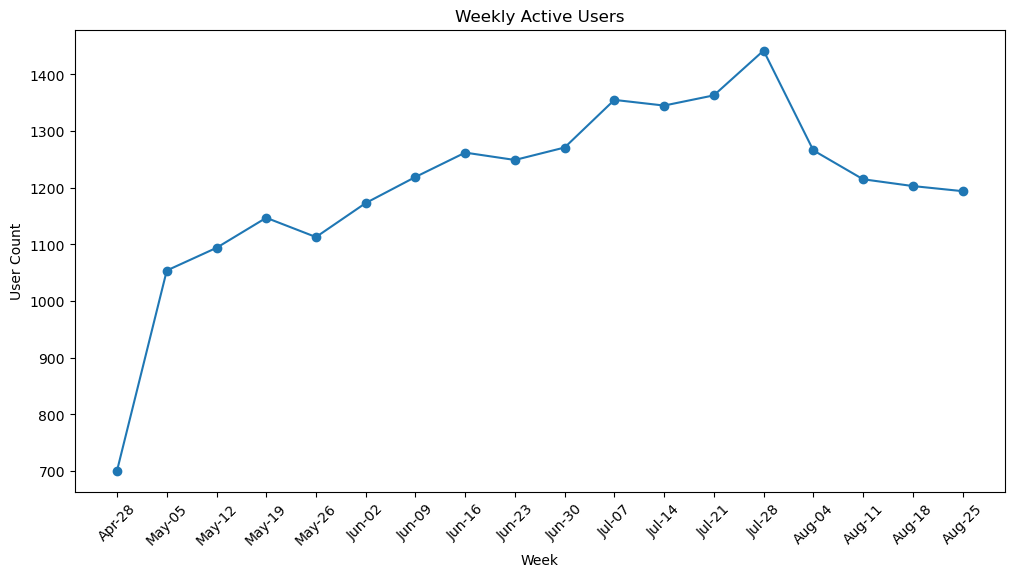

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(wau['week_code'], wau['weekly_active_users'], marker='o')
plt.xlabel('Week')
plt.ylabel('User Count')
plt.title('Weekly Active Users')
plt.xticks(rotation=45)
plt.savefig('./images/engagement_dip.png')
plt.show()

### Step 1: New User Flow Breakdown
- **Hypo:** Fewer new users are signing up and getting activated, leading to a new decline in WAU
- **What I did:** Plotted weekly signup and activation users
- **Finding:** There was indeed a sharp dip during the week of August 4, but the decline appear temporary. i.e. It does not fully explain the continued WAU decline over the folllowing 2-3 weeks

#### Next Step
Coordinate with the marketing or user acquisition team to understand if there were campaign gaps or changes in targeting during this time

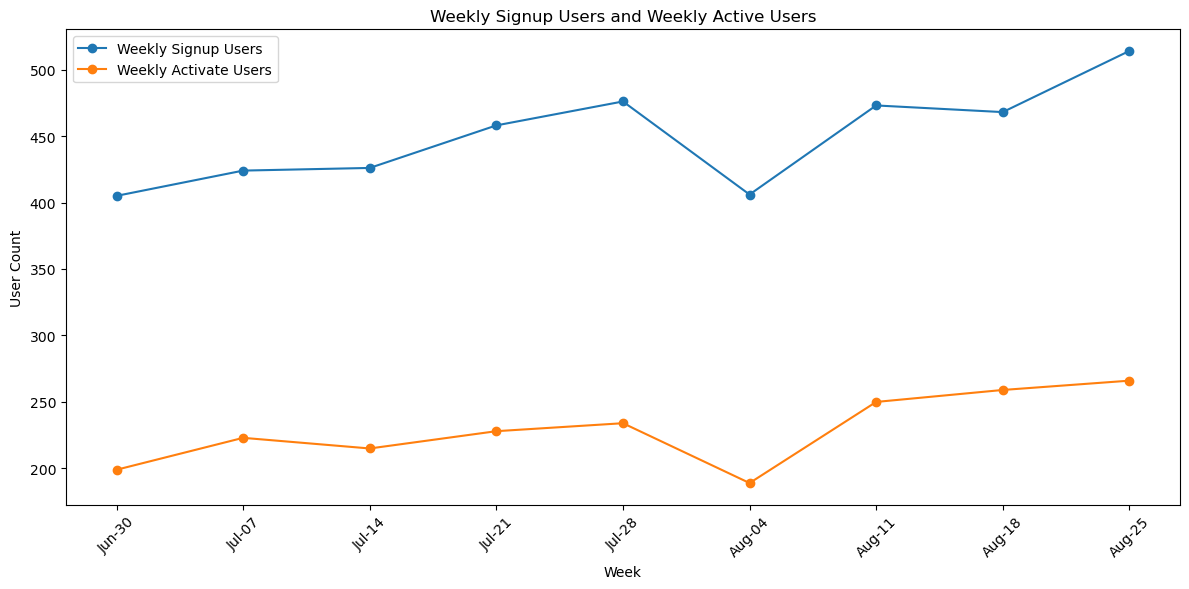

In [13]:
weekly_new_users = """
SELECT
  strftime('%b-%d', date_trunc('week', u.created_at)) AS create_week_code,
  date_trunc('week', u.created_at) AS create_week,
  COUNT(DISTINCT u.user_id) AS weekly_signup_users,
  COUNT(DISTINCT (CASE WHEN u.state = 'active' THEN user_id END)) AS weekly_activate_users
FROM read_csv_auto('./data/yammer_users.csv') as u
WHERE u.created_at BETWEEN '2014-06-30' AND '2014-12-31'
GROUP BY create_week
ORDER BY create_week
"""
wnu = duckdb.query(weekly_new_users).to_df()

plt.figure(figsize=(12, 6))
plt.plot(wnu['create_week_code'], wnu['weekly_signup_users'], label='Weekly Signup Users', marker='o')
plt.plot(wnu['create_week_code'], wnu['weekly_activate_users'], label='Weekly Activate Users', marker='o')
plt.xlabel('Week')
plt.ylabel('User Count')
plt.title('Weekly Signup Users and Weekly Active Users')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Cohort-Based WAU Analysis
- **Hypo:** A temp spike in new users may have led to low-retention cohorts that disengaged rapidly
- **What I did:** Segmented weekly active users by their "user age" to check if specific cohorts contributed mostly to the drop
- **Finding:** All cohorts showed a decline in WAU week-over-week growth starting week of August 4. This suggests that the issues is broad and not tied to a single cohort or one-time marketing spike.

In [19]:
users = duckdb.query(
    """
    SELECT
        user_id, 
        date_trunc('week', created_at) AS cohort_week
    FROM read_csv_auto('./data/yammer_users.csv')
    WHERE activated_at IS NOT NULL
    """).to_df()

login_events = duckdb.query("""
    SELECT
        user_id, 
        date_trunc('week', occurred_at) AS event_week
    FROM read_csv_auto('./data/yammer_events.csv')
    WHERE occurred_at BETWEEN '2014-05-05' AND '2014-09-01' AND
            event_type = 'engagement' AND
            event_name = 'login'
""").to_df()

user_events = login_events.merge(users, on='user_id', how='inner')
user_events['user_life_week'] = (pd.to_datetime('2014-09-01') - pd.to_datetime(user_events['cohort_week'])).dt.days // 7
user_events['user_life_week_group'] = user_events['user_life_week'].apply(lambda x: str(x) if x < 10 else '10+')
life_matrix = user_events.groupby(['event_week', 'user_life_week_group'])['user_id'].count().unstack(fill_value=0)
cols = sorted([c for c in life_matrix.columns if c != '10+'], key=lambda x: int(x)) + (['10+'] if '10+' in life_matrix.columns else [])
life_matrix_grouped = life_matrix[cols]

life_matrix_pct = life_matrix_grouped.pct_change(fill_method=None) * 100
life_matrix_pct.round(1)

user_life_week_group,1,2,3,4,5,6,7,8,9,10+
event_week,,,,,,,,,,
2014-05-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1
2014-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.3
2014-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.5
2014-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.9
2014-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
2014-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.7
2014-06-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,-14.4


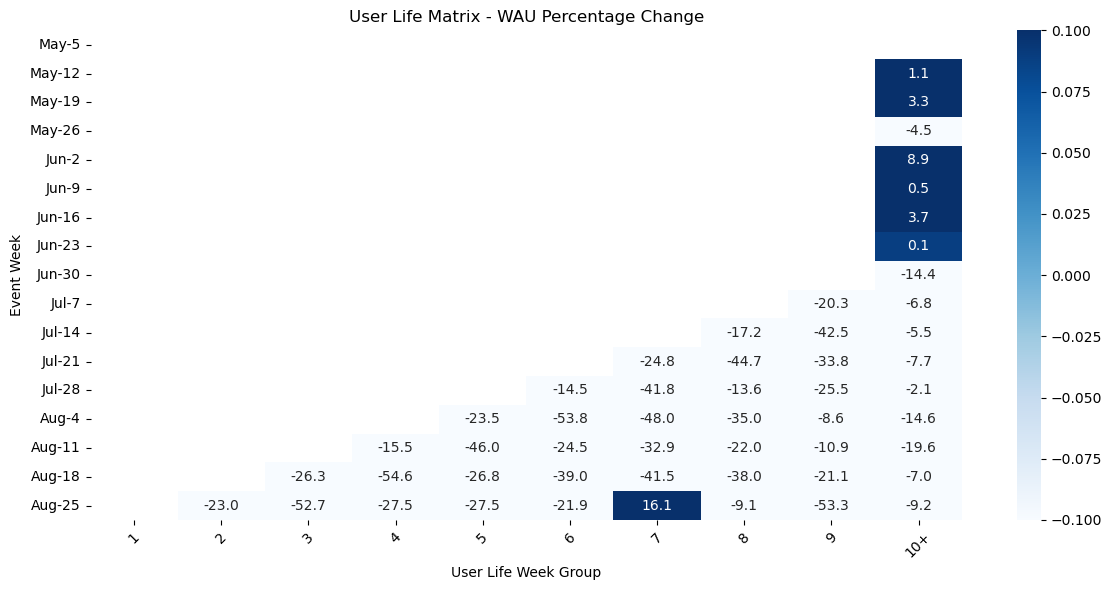

In [20]:
life_matrix_pct_short = life_matrix_pct.copy()
life_matrix_pct_short.index = life_matrix_pct_short.index.strftime('%b-%-d')

plt.figure(figsize=(12, 6))
sns.heatmap(life_matrix_pct_short, annot=True, fmt='.1f', cmap='Blues')
plt.title('User Life Matrix - WAU Percentage Change')
plt.xlabel('User Life Week Group')
plt.ylabel('Event Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Step 3 Device Type Analysis
- **Hypo:** A platform-specific bug or experience issue may have caused engagement to drop
- **What I did:** Broke down WAU by device type (desktop, phone, tablet)
- **Finding:**  There was a notable decrease in mobile engagement (phone and tablet users) the week of August 4, while desktop remained relatively stable.

#### Newx Step
Consult with the monbile engineering and QA teams to check for recent app releases, outrages, or SDK issues that could have impacted mobile usage.

In [21]:
engagement_device = duckdb.query(
    """
    SELECT
        strftime('%b-%d', date_trunc('week', e.occurred_at)) AS event_week_code,
        date_trunc('week', e.occurred_at) AS event_week,
        COUNT(DISTINCT e.user_id) AS weekly_active_users,
        COUNT(DISTINCT CASE WHEN e.device IN ('macbook pro','lenovo thinkpad','macbook air','dell inspiron notebook',
          'asus chromebook','dell inspiron desktop','acer aspire notebook','hp pavilion desktop','acer aspire desktop','mac mini')
          THEN e.user_id ELSE NULL END) AS computer,
        COUNT(DISTINCT CASE WHEN e.device IN ('iphone 5','samsung galaxy s4','nexus 5','iphone 5s','iphone 4s','nokia lumia 635',
       'htc one','samsung galaxy note','amazon fire phone') THEN e.user_id ELSE NULL END) AS phone,
        COUNT(DISTINCT CASE WHEN e.device IN ('ipad air','nexus 7','ipad mini','nexus 10','kindle fire','windows surface',
        'samsung galaxy tablet') THEN e.user_id ELSE NULL END) AS tablet
    FROM read_csv_auto('./data/yammer_events.csv') AS e
    WHERE occurred_at >= '2014-6-30'
        AND e.event_type = 'engagement'
        AND e.event_name = 'login'
    GROUP BY 2
    ORDER BY 2
    """).to_df()

# Calculate week-over-week % change for each device type
wow_table = engagement_device.set_index('event_week_code')[['weekly_active_users', 'computer', 'phone', 'tablet']].pct_change() * 100
wow_table = wow_table.round(1)
wow_table.T

event_week_code,Jun-30,Jul-07,Jul-14,Jul-21,Jul-28,Aug-04,Aug-11,Aug-18,Aug-25
weekly_active_users,NaN,6.6,-0.7,1.3,5.8,-12.2,-4.0,-1.0,-0.7
computer,NaN,8.9,2.6,0.3,5.3,-4.0,-3.0,-1.2,-1.3
phone,NaN,2.2,-2.2,4.0,-2.2,-16.5,-10.8,-2.3,3.0
tablet,NaN,4.1,-4.0,0.0,10.6,-31.1,-7.8,-5.2,3.4


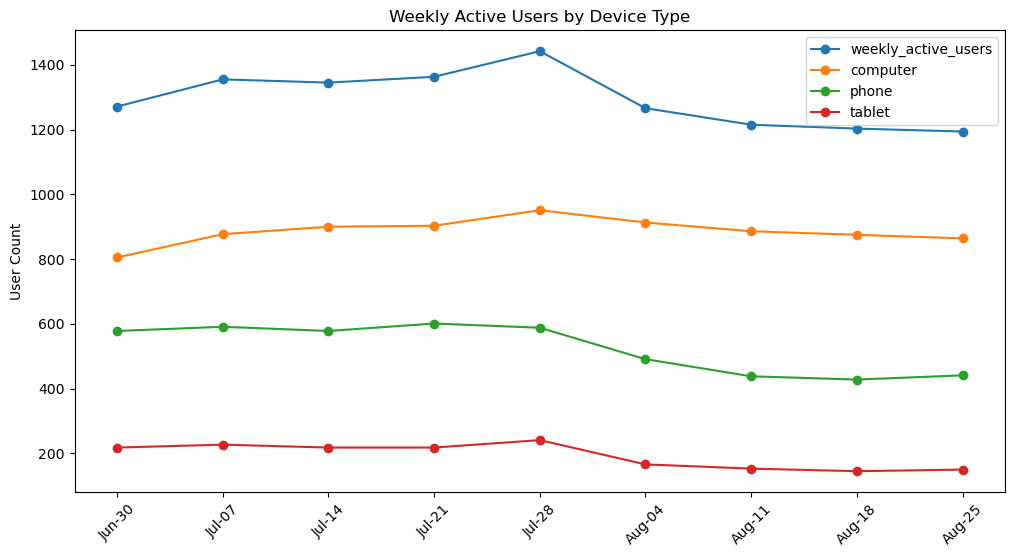

In [22]:
plt.figure(figsize=(12, 6))
for col in ['weekly_active_users', 'computer', 'phone', 'tablet']:
    plt.plot(engagement_device['event_week_code'], engagement_device[col], marker='o', label=col)
plt.title('Weekly Active Users by Device Type')
plt.ylabel('User Count')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Step 4: Email-Driven Engagement Analysis
- **Hypo:** A large share of user engagement on Yammer is triggered via email. A drop in email-driven traffic could directly affect WAU
- **What I did:** Reviewed weeklhy email metrics: total email sent, total opens, total click-throughs
- **Finding**
    - Emails sent continuted increasing
    - Open counts stayed stable
    - But click-through counts dropped significantly starting the week of August 4, indicating that users were receiving eamils but not clicking through

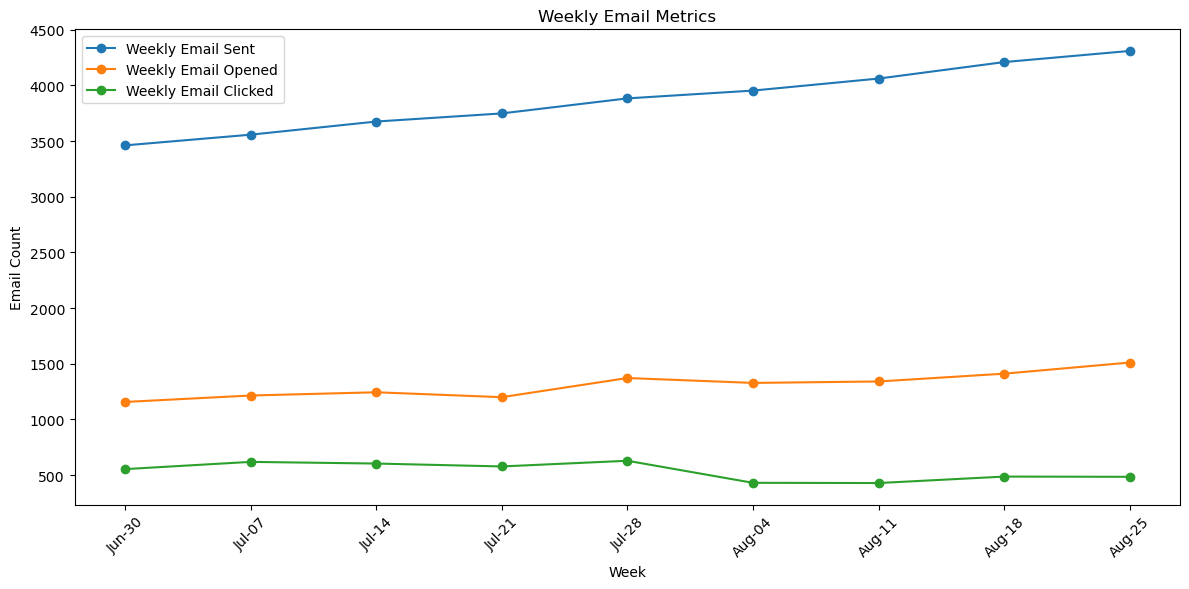

In [23]:
email_overall = duckdb.query("""
SELECT
    strftime('%b-%d', date_trunc('week', occurred_at)) AS event_week_code,
    date_trunc('week', occurred_at) AS event_week,
    COUNT(DISTINCT CASE WHEN action ='sent_weekly_digest' OR action = 'sent_reengagement_email' THEN user_id END) AS weekly_emails_sent,
    COUNT(DISTINCT CASE WHEN action = 'email_open' THEN user_id END) AS weekly_emails_opened,
    COUNT(DISTINCT CASE WHEN action = 'email_clickthrough' THEN user_id END) AS weekly_emails_clicked
FROM read_csv_auto('./data/yammer_emails.csv')
WHERE occurred_at >= '2014-6-30'
GROUP BY 2
ORDER BY 2
""").to_df()

plt.figure(figsize=(12, 6))
plt.plot(email_overall['event_week_code'], email_overall['weekly_emails_sent'], label='Weekly Email Sent', marker='o')
plt.plot(email_overall['event_week_code'], email_overall['weekly_emails_opened'], label='Weekly Email Opened', marker='o')
plt.plot(email_overall['event_week_code'], email_overall['weekly_emails_clicked'], label='Weekly Email Clicked', marker='o')
plt.xlabel('Week')
plt.ylabel('Email Count')
plt.title('Weekly Email Metrics')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Step 5: Email Type deep dive
- **What I did:** Separated email metrics by email type
    -  "Weekly Digest":  summarizes key network activity
    - "Re-engagement emails": emails sent to dormant users
- **Finding:** The drop in CTR was isloated to weekly digest emails, which saw a sharp drop in CTR begining the week of August 4. This aligns precisely with the WAU dip.

#### Next Step
Investigate with the email product and data engineering teams to confirm whether changes were made to the digest logic, formatting, or targeting logic during this period

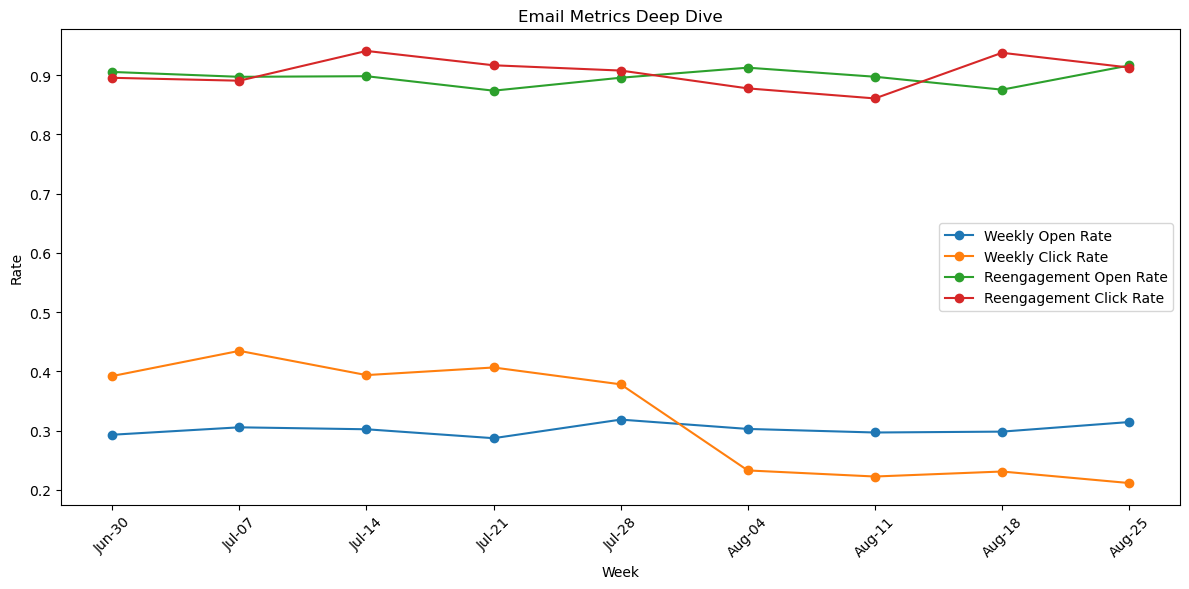

In [24]:
email_metrics = duckdb.query("""
SELECT
    event_week_code,
    event_week,
    weekly_emails_opened / weekly_emails_sent AS weekly_open_rate,
    weekly_emails_clicked / weekly_emails_opened AS weekly_click_rate,
    reengagement_emails_opened / reengagement_emails_sent AS reengagement_open_rate,
    reengagement_emails_clicked / reengagement_emails_opened AS reengagement_click_rate
FROM(                             
    SELECT
        strftime('%b-%d', date_trunc('week', e1.occurred_at)) AS event_week_code,
        date_trunc('week', e1.occurred_at) AS event_week,
        COUNT(DISTINCT CASE WHEN e1.action = 'sent_weekly_digest' THEN e1.user_id END) AS weekly_emails_sent,
        COUNT(DISTINCT CASE WHEN e1.action = 'sent_weekly_digest' THEN e2.user_id END) AS weekly_emails_opened,
        COUNT(DISTINCT CASE WHEN e1.action = 'sent_weekly_digest' THEN e3.user_id END) AS weekly_emails_clicked,
        COUNT(DISTINCT CASE WHEN e1.action = 'sent_reengagement_email' THEN e1.user_id END) AS reengagement_emails_sent,
        COUNT(DISTINCT CASE WHEN e1.action = 'sent_reengagement_email' THEN e2.user_id END) AS reengagement_emails_opened,
        COUNT(DISTINCT CASE WHEN e1.action = 'sent_reengagement_email' THEN e3.user_id END) AS reengagement_emails_clicked
    FROM read_csv_auto('./data/yammer_emails.csv') e1
    LEFT JOIN read_csv_auto('./data/yammer_emails.csv') e2
        ON e1.user_id = e2.user_id
        AND e2.occurred_at > e1.occurred_at
        AND date_diff('minute', e1.occurred_at, e2.occurred_at) < 5
        AND e2.action = 'email_open'
    LEFT JOIN read_csv_auto('./data/yammer_emails.csv') e3
        ON e2.user_id = e3.user_id
        AND e3.occurred_at > e2.occurred_at
        AND date_diff('minute', e2.occurred_at, e3.occurred_at) < 5
        AND e3.action = 'email_clickthrough'
    WHERE e1.occurred_at > '2014-6-30'
        AND e1.action IN ('sent_weekly_digest','sent_reengagement_email')
    GROUP BY 2) a
ORDER BY 2
""").to_df()

plt.figure(figsize=(12, 6))
plt.plot(email_metrics['event_week_code'], email_metrics['weekly_open_rate'], label='Weekly Open Rate', marker='o')
plt.plot(email_metrics['event_week_code'], email_metrics['weekly_click_rate'], label='Weekly Click Rate', marker='o')
plt.plot(email_metrics['event_week_code'], email_metrics['reengagement_open_rate'], label='Reengagement Open Rate', marker='o')
plt.plot(email_metrics['event_week_code'], email_metrics['reengagement_click_rate'], label='Reengagement Click Rate', marker='o')
plt.xlabel('Week')
plt.ylabel('Rate')
plt.title('Email Metrics Deep Dive')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()